# 02 IRL: 02 Maximum Entropy

https://ja.wikipedia.org/wiki/最大エントロピー原理  
https://www.slideshare.net/YusukeNakata1/maximum-entropy-irl

---
## 0.Setup

In [1]:
import numpy as np
np.set_printoptions(precision=2)  # 数値桁数を指定．
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import importlib

from datetime import datetime

---
## 1.Environment

In [2]:
class Environment(object):
    def __init__(self,
                liability_CF=np.array([0, 0, 0, 0, -5]),
                initial_asset=10,
                max_asset=10,
                bunkrupt_penalty=-30,
                gamma=0.99):
        self.t = 0
        self.liability_CF = liability_CF
        self.initial_asset = initial_asset
        self.max_asset = max_asset
        self.bunkrupt_penalty = bunkrupt_penalty
        self.gamma = gamma
        self.term = len(liability_CF)  # 行動選択回数はこの通りだが，状態数としてはこれに終端状態が加わる．
        
        
    def policy_iteration(self, R):  # R = t, S, A
        # 報酬体系R(t, S, A)における，最適状態価値関数Vと最適行動価値関数Qを返す．
        V = np.zeros(shape=(self.term+1, self.n_actions))  # t, S
        Q = np.zeros(shape=(self.term+1, self.n_states, self.n_actions))  # t, S, A
        
        for t in range(self.term-1, 0-1, -1):  # V, Qのtの最大値はself.term-1+1である．
            V[t] = np.array([np.max(R[t, s, :s+1] + self.gamma * V[t+1][:s+1]) for s in range(self.n_states)])
            Q[t] = R[t] + self.gamma * V[t+1].reshape(1, -1)  # s, a
            # V[t+1]はs成分しか持っていない．しかし，Q[t, s, a] = R[t, s, a] + gamma * V[t+1, a]である（この系の場合）．
            # このため，reshapeでV[t+1][a]をV[t+1, 0, a]にしている（0はダミー軸）．
        
        # 実行不可能なs,aの組合せをnanで上書きする．
        Q[:, np.array(1-np.tri(self.n_states), dtype=bool)] = np.nan
        
        return V, Q
    
    
    def calc_greedy_policy(self, Q):  # t, S, A
        # 行動価値関数Qに対するグリーディ方策を返す(t, S)．実行不可能な組合せはnanが入っている前提．
        return np.array([np.nanargmax(Q[t, :, :], axis=-1) for t in range(self.term)])  # t, s
        # nanargmaxでないと，nanを最大インデックスと見なすので注意．
        
        
    def calc_value(self, R, policy):  # R(t, S, A), policy(t, S)
        # 報酬体系Rにおいて方策policyに基づく行動価値関数Qを返す（t, S, A）．
        V = np.zeros(shape=(self.term+1, self.n_states))
        Q = np.zeros(shape=(self.term+1, self.n_states, self.n_actions))  # t, S, A
        V[self.term-1] = R[self.term-1][np.arange(self.n_states), policy[self.term-1, :]]
        Q[self.term-1] = R[self.term-1]
        for t in range(self.term-2, 0-1, -1):
            V[t] = R[t][np.arange(self.n_states), policy[t, :]] + self.gamma * V[t+1][policy[t, :]]
            Q[t] = R[t] + self.gamma * Q[t+1][np.arange(self.n_actions), policy[t+1, :]].reshape(1, -1)
            # Q[t, s, a] = R[t, s, a] + gamma * Q[t+1, a, policy[t+1, a]]である（s_t+1 = aであるため）．
                    
        # 実行不可能なs, aの組合せをnanで上書きする．
        Q[:, np.array(1-np.tri(self.n_states), dtype=bool)] = np.nan
        
        return V, Q
    
    
    def calc_all_greedy_trajectories(self, greedy_policy, start_all=False):
        # greedy_policyに従うトラジェクトリ全パターンを返す．
        # これは実質的にはgreedy_policyそのものだが，フォーマットのみ異なる(t, s)→(t, s, a)
        # また，ここを起点にして，トラジェクトリの要素のうちの幾つかを削除したりすることができる．
        trajectories = []
        
        if start_all==False:
            for t in range(self.term):
                for s in range(self.n_states):
                    trajectories.append([t, s, greedy_policy[t, s]])

            return trajectories
        
        else:
            for t in range(self.term):
                for s in range(self.n_states):
                    trajectories.append([t, s, greedy_policy[t, s]])
                    for t_in in range(t+1, self.term):
                        a = trajectories[-1][2]  # t, s, a
                        trajectories.append([t_in, a, greedy_policy[t_in, a]])
                        
            return trajectories
   
    
    ###################################################################################################
    # methods for maximum entropy method.
    def calc_empirical_feature_count(self, trajectories):
        f = np.zeros(shape=(self.term, self.n_states, self.n_actions))
        for trajectory in trajectories:
            f[trajectory[0], trajectory[1], trajectory[2]] += 1
            
        return f
    
    
    def calc_state_action_density(self, trajectories, policy):
        start_state_density = np.zeros(self.n_states)
        for trajectory in trajectories:
            if trajectory[0]==0:
                start_state_density[trajectory[1]] += 1
        start_state_density /= np.sum(start_state_density)
        
        density = np.zeros(shape=(self.term, self.n_states, self.n_actions))  # t, s, a
        density[0][np.arange(self.n_states), policy[0, :]] = start_state_density
        for t in range(1, self.term):
            start_state_density = np.sum(density[t-1], axis=-1)  # s, a -> s
            density[t][np.arange(self.n_states), policy[t, :]] = start_state_density
            
        return density / np.sum(density)
    
    
    def calc_state_action_density_max_entropy(self, start_state_density, R):
        # 各種正規化
        start_state_density /= np.sum(start_state_density)        
        R = R - np.max(R)
        
        # トラジェクトリの発生率はexp(R)比例である．これは，分解するとexp(R1+R2+...)なので，exp(R1)*exp(R2)*...とできる．
        # Backward pass
        Z = np.zeros(shape=(self.term+1, self.n_states, self.n_actions))
        Z[-1] = 1
        for t in range(self.term-1, 0-1, -1):
            Z[t] = np.exp(R[t, :, :]) * np.sum(Z[t+1], axis=-1).reshape(1, 1, -1)  # s, a
            Z[t][np.array(1-np.tri(self.n_states), dtype=bool)] = 0  # override impossible segment.
        Z = Z + np.min(Z[Z!=0])  # 収束につれて特定のトラジェクトリの確率がほぼゼロになり，エラーになるため．
        Z[:, np.array(1-np.tri(self.n_states), dtype=bool)] = 0
        policy = Z / np.sum(Z, axis=-1, keepdims=True)  # t, s, a ~ このpolicyはこのクラスで用いている他のpolicyとは違い，stochasticでフォーマットが違うので注意．
        
        D = np.zeros(shape=(self.term, self.n_states, self.n_actions))  # t, s, a
        D[0] = start_state_density[0].reshape(-1, 1) * policy[0]  # s, a
        for t in range(1, self.term):
            D[t] = (np.sum(D[t-1], axis=0) + start_state_density[t]).reshape(-1, 1) * policy[t]
            
        if np.any(np.isnan(Z)) or np.any(np.isnan(policy)) or np.any(np.isnan(D)):
            print('nan encountered')
            self.log = []
            self.log.append({'R':np.copy(R), 'Z':np.copy(Z), 'policy':np.copy(policy), 'D':np.copy(D)})
            
        return D / np.sum(D)
        
    
    def maximum_entropy(self, trajectories, start_state_density=None, learning_rate=0.01, n_iterations=1000, 
                       show_process=False, n_show_intervals=100, figsize=(15, 3)):
        self.Rs = []
        empirical_feature_density = self.calc_empirical_feature_count(trajectories)  # このトラジェクトリは重複を許す．
        empirical_feature_density /= np.sum(empirical_feature_density)
        
        if start_state_density is None:
            start_state_density = np.ones(shape=(self.term, self.n_states))
            start_state_density /= np.sum(start_state_density)
        
        R = (np.random.uniform(size=(self.term, self.n_states, self.n_actions)) - 0.5) * 0.01
        for i in range(n_iterations):
            # V, Q = self.policy_iteration(R)
            # policy = self.calc_greedy_policy(Q)
            # optimized_feature_density = self.calc_state_action_density(trajectories, policy)
            optimized_feature_density = self.calc_state_action_density_max_entropy(start_state_density, R)  # このトラジェクトリは重複を基本的に許さない（開始状態のみが必要）．
            
            if np.any(np.isnan(optimized_feature_density)):
                print('encountered nan at iteration : {}'.format(i))
                break
            
            R += learning_rate * (empirical_feature_density - optimized_feature_density)
            
            if show_process and i % n_show_intervals == 0:
                self.Rs.append({'R':np.copy(R), 'opt_density':np.copy(optimized_feature_density)})
                print('---------------------------------------------------------------------')
                print('{} th iteration...'.format(i))
                print('R')
                fig = plt.figure(figsize=figsize)
                for t in range(self.term):
                    ax1 = fig.add_subplot(1, 5, 1+t)
                    ax1 = sns.heatmap(R[t], annot=False, cmap='jet', square=True)
                    ax1.set_xlabel('action')
                    ax1.set_ylabel('state')
                plt.tight_layout()
                plt.show()
                
                print('empirical feature density')
                fig = plt.figure(figsize=figsize)
                for t in range(self.term):
                    ax1 = fig.add_subplot(1, 5, 1+t)
                    ax1 = sns.heatmap(empirical_feature_density[t], annot=False, cmap='jet', square=True)
                    ax1.set_xlabel('action')
                    ax1.set_ylabel('state')
                plt.tight_layout()
                plt.show()
                
                print('optimized feature density')
                fig = plt.figure(figsize=figsize)
                for t in range(self.term):
                    ax1 = fig.add_subplot(1, 5, 1+t)
                    ax1 = sns.heatmap(optimized_feature_density[t], annot=False, cmap='jet', square=True)
                    ax1.set_xlabel('action')
                    ax1.set_ylabel('state')
                plt.tight_layout()
                plt.show()

                print('dR')
                fig = plt.figure(figsize=figsize)
                for t in range(self.term):
                    ax1 = fig.add_subplot(1, 5, 1+t)
                    ax1 = sns.heatmap((empirical_feature_density - optimized_feature_density)[t], annot=False, cmap='jet', square=True)
                    ax1.set_xlabel('action')
                    ax1.set_ylabel('state')
                plt.tight_layout()
                plt.show()
                
                
        return R


    ###################################################################################################
    @property
    def n_states(self):
        return self.max_asset + 1
        
    @property
    def n_actions(self):
        return self.max_asset + 1
    
    @property
    def dim_actions(self):
        return 1

    
    ###################################################################################################
    def calc_R_as_SP_annuity(self):
        # earnings distribution
        R = np.zeros(shape=(self.term, self.n_states, self.n_actions))
        for t in range(self.term):
            for s in range(self.n_states):
                for a in range(s+1):
                    R[t, s, a] = max(0, s-a)
                    
        R[-1, :, :] += self.gamma * np.arange(self.n_actions).reshape(1, -1)  # remained asset at EoY
        R[-1, :, :] += self.gamma * self.liability_CF[-1]  # final payout
        R[-1, :, :-self.liability_CF[-1]] += self.bunkrupt_penalty  # bunkrupt penalty
        
        R[:, np.array(1-np.tri(self.n_states), dtype=bool)] = np.nan # cut out impossible action
        
        return R
        

In [3]:
def show_VPQ(env, R, annot=False, figsize=(16, 6), show_RQ=True):
    V, Q = env.policy_iteration(R)
    policy = env.calc_greedy_policy(Q)
    
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(1, 2, 1)
    ax1 = sns.heatmap(V, annot=annot, cmap='jet', square=True)
    ax1.set_title('V')
    ax1.set_xlabel('state')
    ax1.set_ylabel('t')
    
    ax2 = fig.add_subplot(1, 2, 2)
    ax2 = sns.heatmap(policy, annot=True, cmap='jet', square=True)
    ax2.set_title('Greedy Policy')
    ax2.set_xlabel('action')
    ax2.set_ylabel('t')
    
    plt.show()
    
    if show_RQ:
        for t in range(env.term):
            fig = plt.figure(figsize=figsize)
            ax1 = fig.add_subplot(1, 2, 1)
            ax1 = sns.heatmap(R[t], annot=annot, cmap='jet', square=True)
            ax1.set_title('R : t={}'.format(t))
            ax1.set_xlabel('action')
            ax1.set_ylabel('state')
            
            ax2 = fig.add_subplot(1, 2, 2)
            ax2 = sns.heatmap(Q[t], annot=annot, cmap='jet', square=True)
            ax2.set_title('Q : t={}'.format(t))
            ax2.set_xlabel('action')
            ax2.set_ylabel('state')
            
            plt.show()
    

In [4]:
env = Environment()
R = env.calc_R_as_SP_annuity()

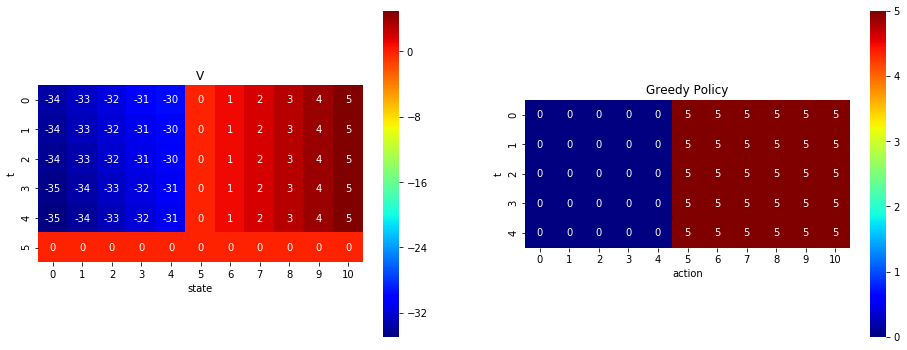

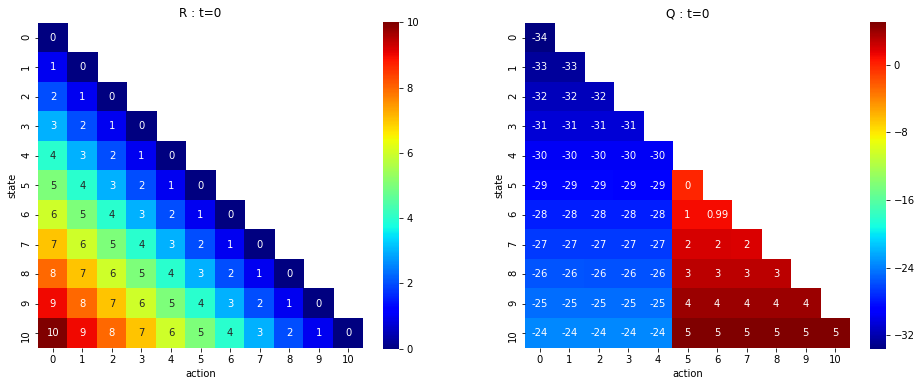

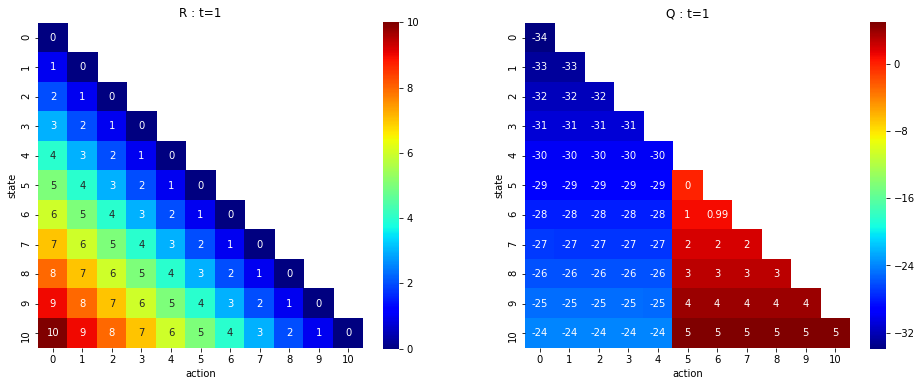

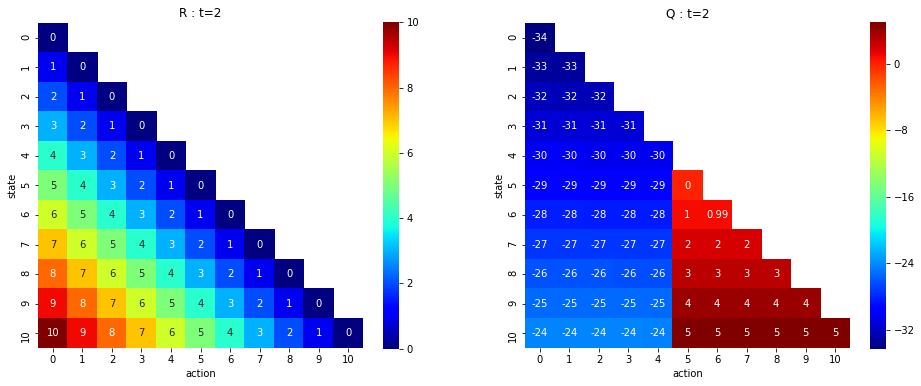

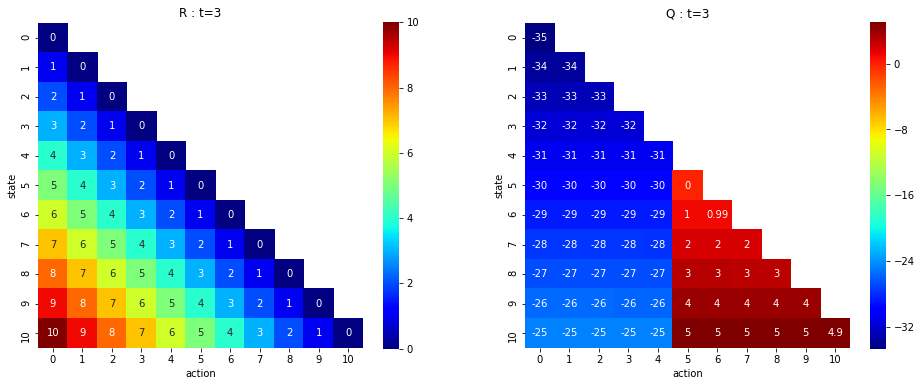

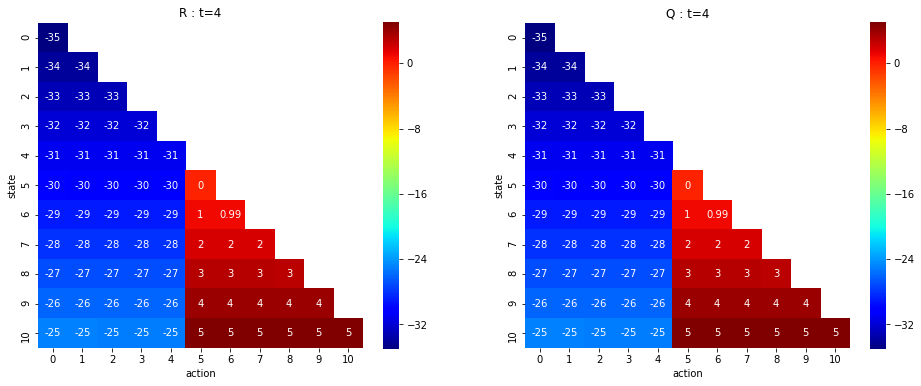

In [5]:
show_VPQ(env, R, annot=True)

In [6]:
# check〜最適価値関数と，最適価値関数に対するグリーディ方策から生成される価値関数とが一致することを確認する．
R = env.calc_R_as_SP_annuity()
V, Q = env.policy_iteration(R)
V_, Q_ = env.calc_value(R, env.calc_greedy_policy(Q))

for t in range(env.term):
    print(np.all(V[t]==V_[t]))
    print(np.all(Q[t][np.array(np.tri(env.n_states), dtype=bool)]==Q_[t][np.array(np.tri(env.n_states), dtype=bool)]))

True
True
True
True
True
True
True
True
True
True


---
## 2. Linear Maximum Entropy
エキスパート行動$\xi$が得られる確率$P(\xi|\theta)$を最大化するパラメータ$\theta$を勾配上昇法で求める．
このとき，$P(\xi|\theta)$は，$\exp(R(\xi))$（エキスパートの軌跡における報酬）に比例するとしてモデル化する．これは，$\theta\cdot f$（$f$は状態行動対を示す特徴量ベクトル）とする．
このとき，目的関数$P(\xi|\theta)$の$\theta$に関する勾配は，$f_{expert} - \sum_{\xi}P(\xi|\theta)f_\xi$で求めることができる．

原論文では状態にしか即時報酬は依存しないとしているが，これでは責任準備金特有の，早い内に放出した方が利益現在価値が大きくなる，という性質を表すことができない．そのため，原論文の仕様を拡張して，状態行動対に対して各種の定義を行うことにする．  
具体的には，t, s, aのタプルに対してトラジェクトリの訪問を考えることにする．

In [7]:
env = Environment()
R = env.calc_R_as_SP_annuity()
V, Q = env.policy_iteration(R)
policy = env.calc_greedy_policy(Q)
optimized_trajectories = env.calc_all_greedy_trajectories(policy, start_all=True)
optimized_trajectories

[[0, 0, 0],
 [1, 0, 0],
 [2, 0, 0],
 [3, 0, 0],
 [4, 0, 0],
 [0, 1, 0],
 [1, 0, 0],
 [2, 0, 0],
 [3, 0, 0],
 [4, 0, 0],
 [0, 2, 0],
 [1, 0, 0],
 [2, 0, 0],
 [3, 0, 0],
 [4, 0, 0],
 [0, 3, 0],
 [1, 0, 0],
 [2, 0, 0],
 [3, 0, 0],
 [4, 0, 0],
 [0, 4, 0],
 [1, 0, 0],
 [2, 0, 0],
 [3, 0, 0],
 [4, 0, 0],
 [0, 5, 5],
 [1, 5, 5],
 [2, 5, 5],
 [3, 5, 5],
 [4, 5, 5],
 [0, 6, 5],
 [1, 5, 5],
 [2, 5, 5],
 [3, 5, 5],
 [4, 5, 5],
 [0, 7, 5],
 [1, 5, 5],
 [2, 5, 5],
 [3, 5, 5],
 [4, 5, 5],
 [0, 8, 5],
 [1, 5, 5],
 [2, 5, 5],
 [3, 5, 5],
 [4, 5, 5],
 [0, 9, 5],
 [1, 5, 5],
 [2, 5, 5],
 [3, 5, 5],
 [4, 5, 5],
 [0, 10, 5],
 [1, 5, 5],
 [2, 5, 5],
 [3, 5, 5],
 [4, 5, 5],
 [1, 0, 0],
 [2, 0, 0],
 [3, 0, 0],
 [4, 0, 0],
 [1, 1, 0],
 [2, 0, 0],
 [3, 0, 0],
 [4, 0, 0],
 [1, 2, 0],
 [2, 0, 0],
 [3, 0, 0],
 [4, 0, 0],
 [1, 3, 0],
 [2, 0, 0],
 [3, 0, 0],
 [4, 0, 0],
 [1, 4, 0],
 [2, 0, 0],
 [3, 0, 0],
 [4, 0, 0],
 [1, 5, 5],
 [2, 5, 5],
 [3, 5, 5],
 [4, 5, 5],
 [1, 6, 5],
 [2, 5, 5],
 [3, 5, 5],
 [4, 5, 5],
 [1

---------------------------------------------------------------------
0 th iteration...
R


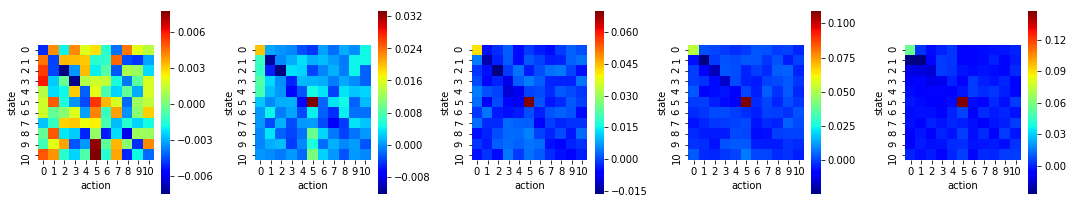

empirical feature density


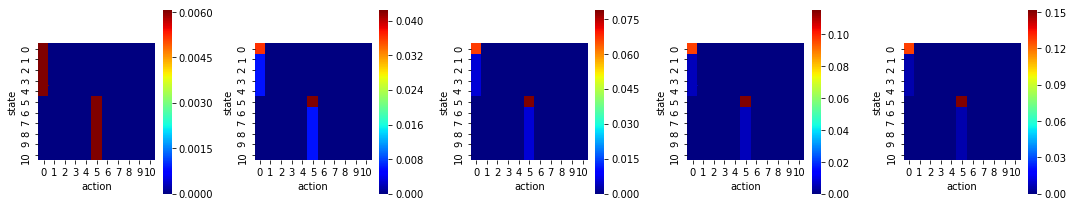

optimized feature density


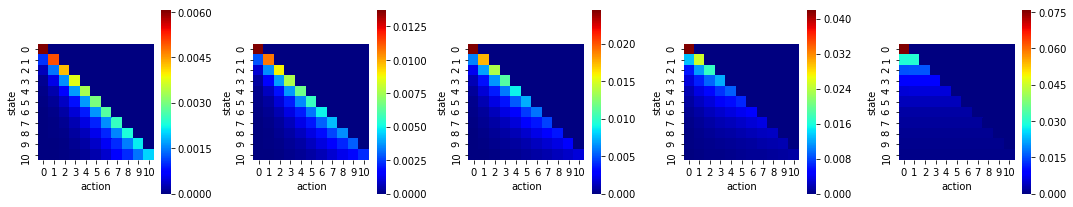

dR


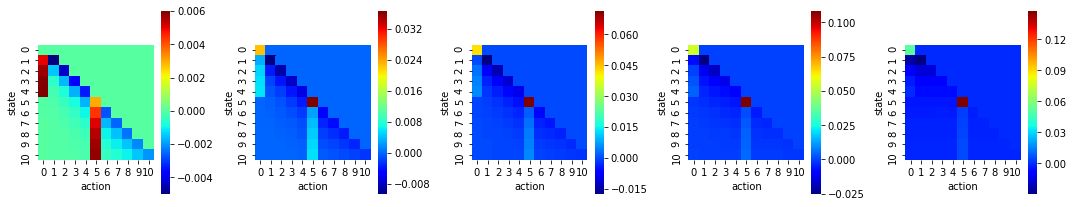

---------------------------------------------------------------------
10000 th iteration...
R


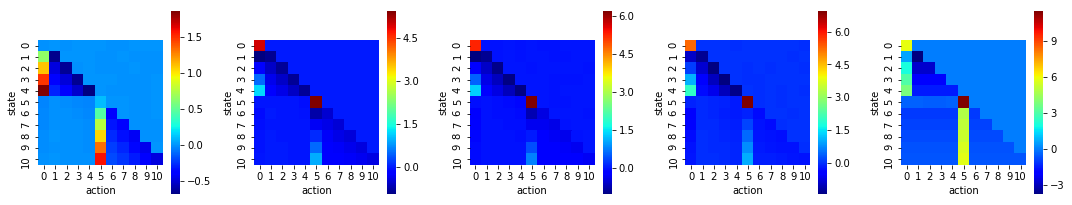

empirical feature density


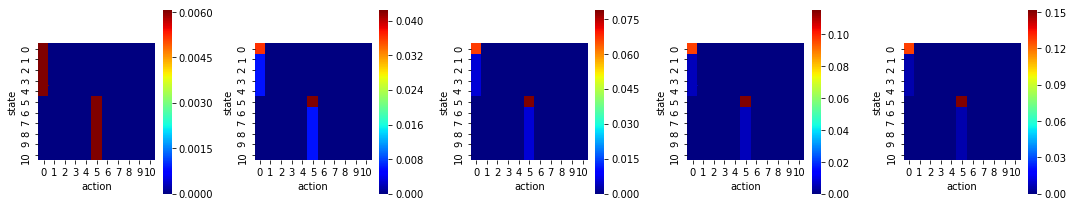

optimized feature density


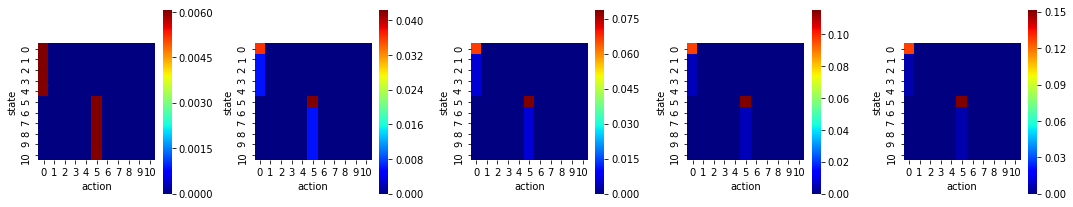

dR


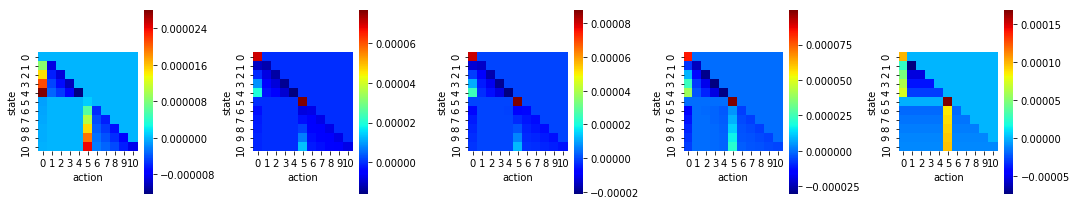

---------------------------------------------------------------------
20000 th iteration...
R


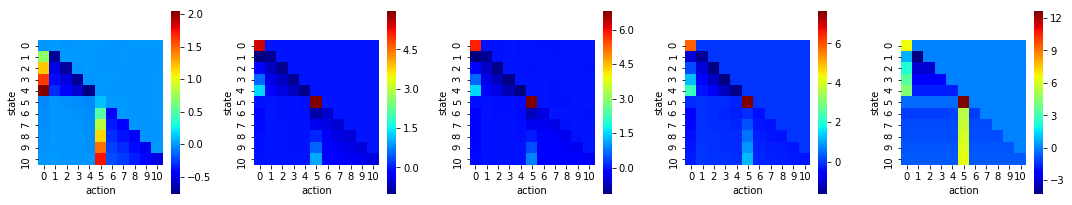

empirical feature density


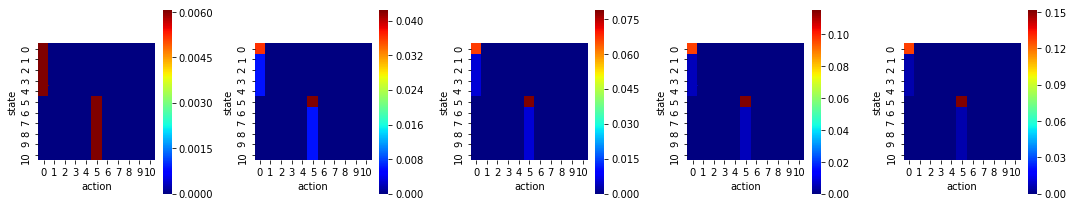

optimized feature density


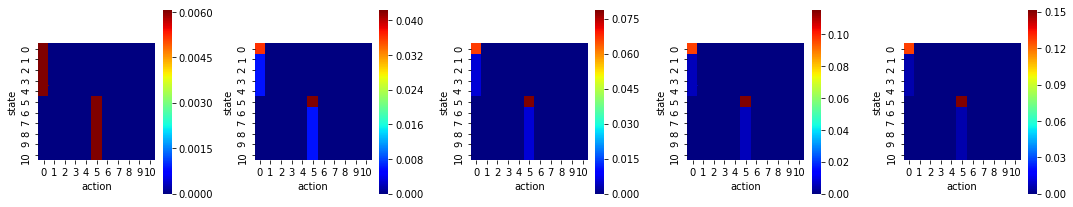

dR


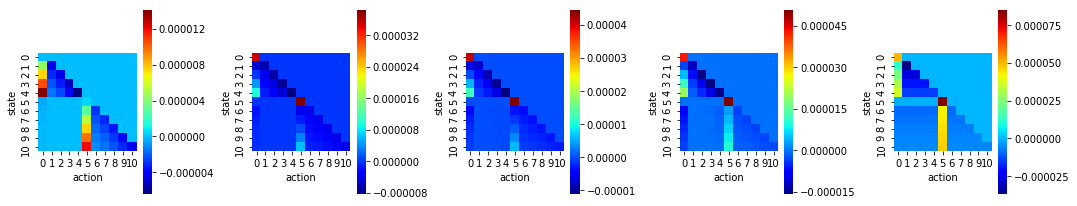

---------------------------------------------------------------------
30000 th iteration...
R


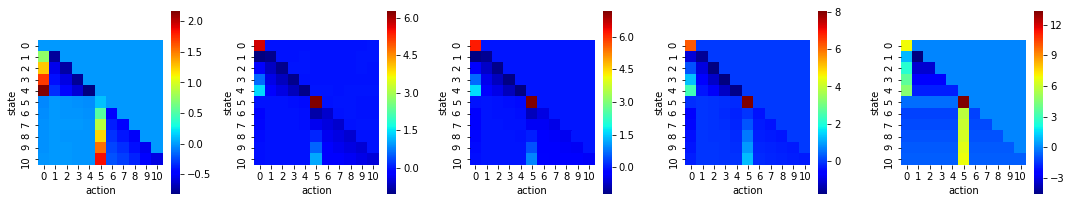

empirical feature density


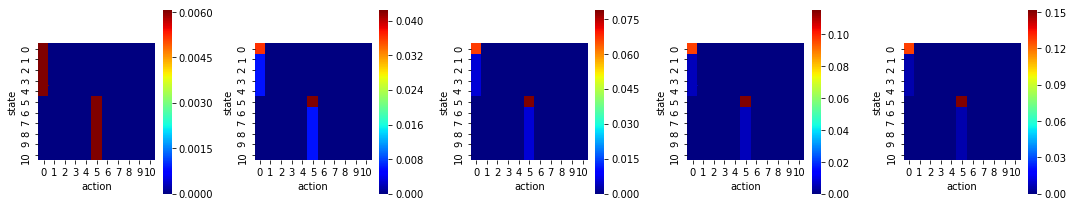

optimized feature density


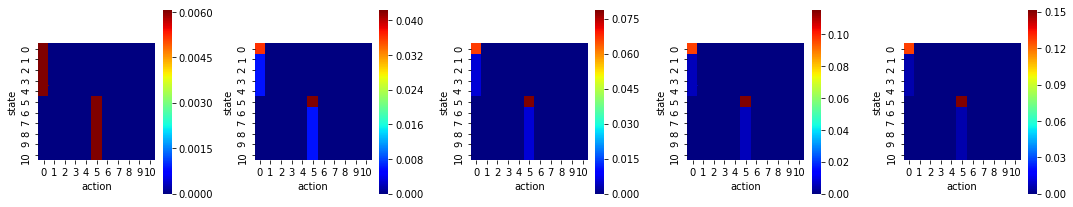

dR


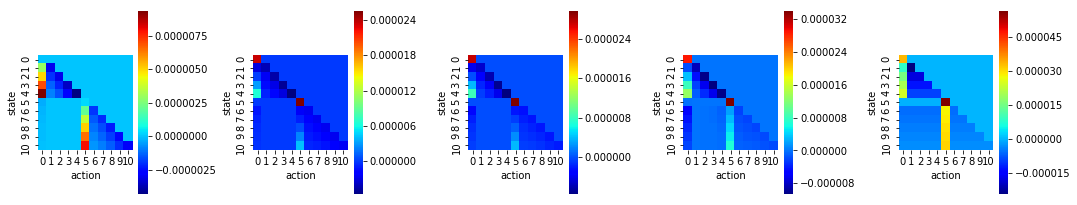

---------------------------------------------------------------------
40000 th iteration...
R


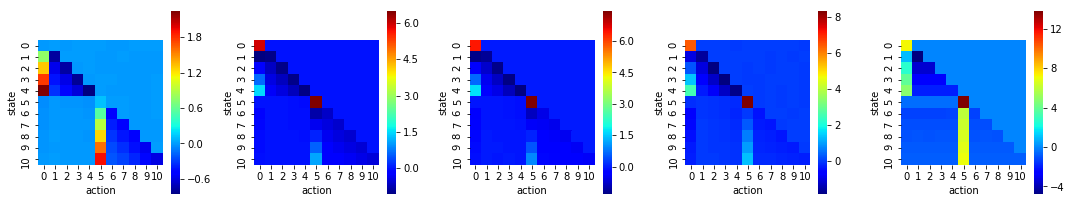

empirical feature density


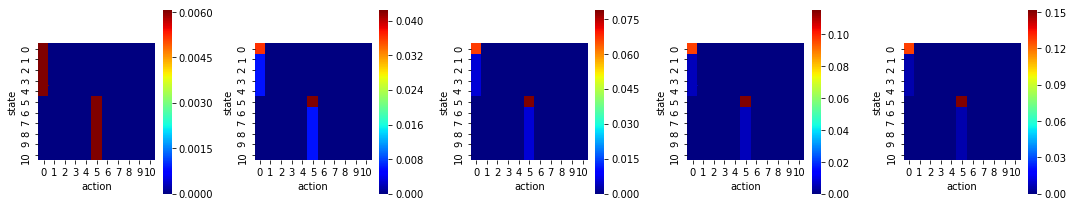

optimized feature density


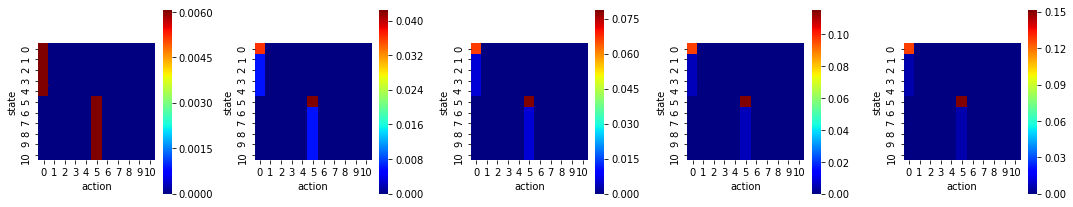

dR


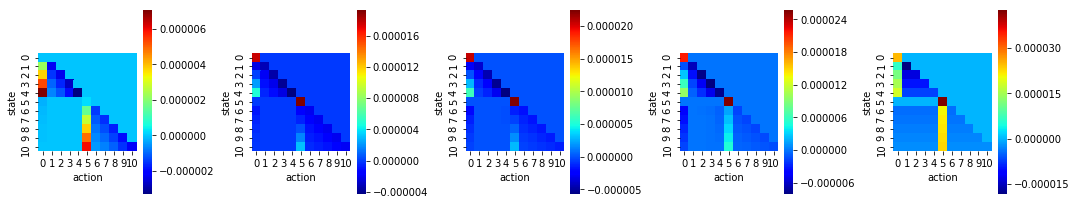

---------------------------------------------------------------------
50000 th iteration...
R


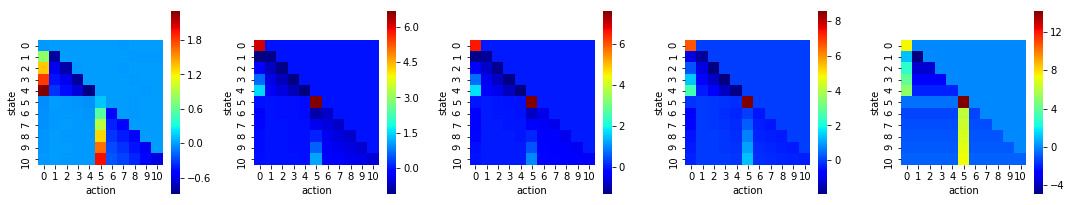

empirical feature density


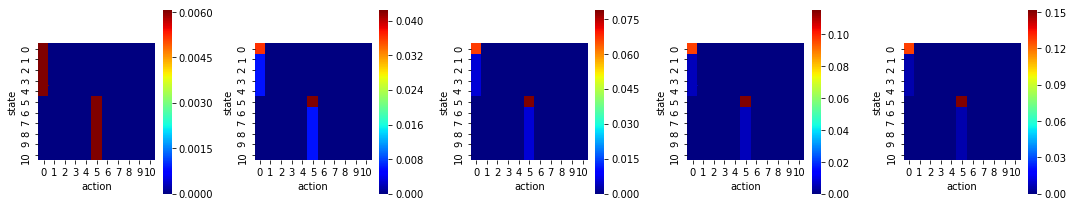

optimized feature density


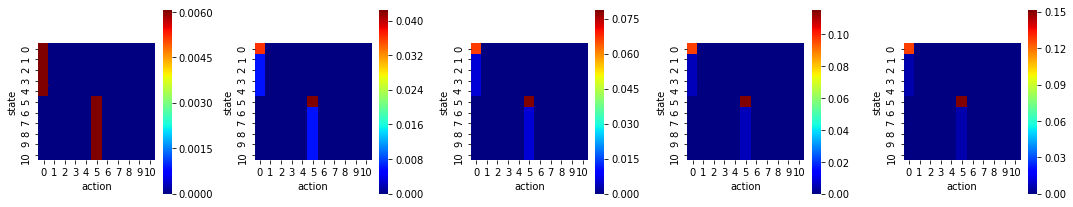

dR


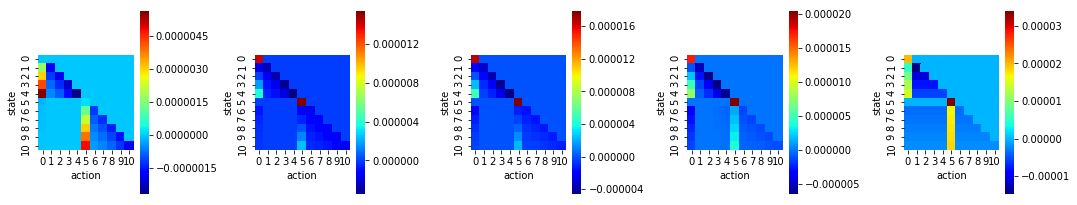

---------------------------------------------------------------------
60000 th iteration...
R


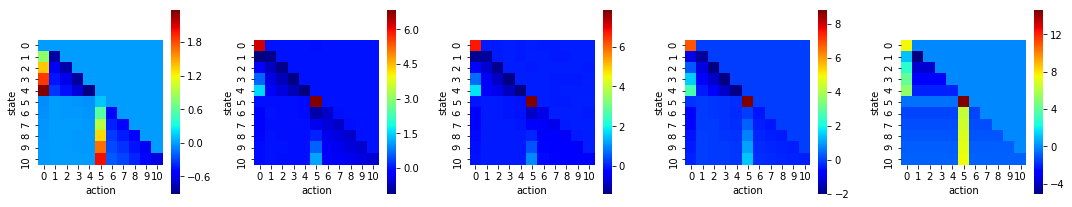

empirical feature density


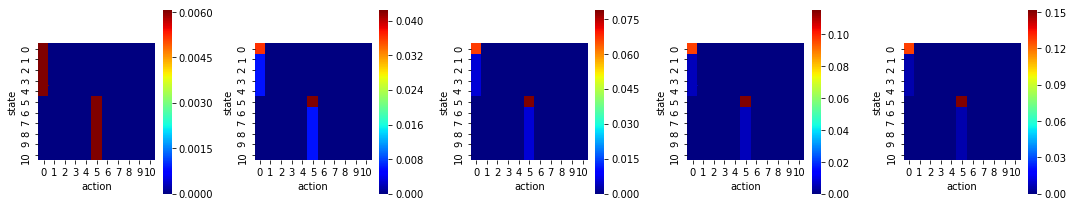

optimized feature density


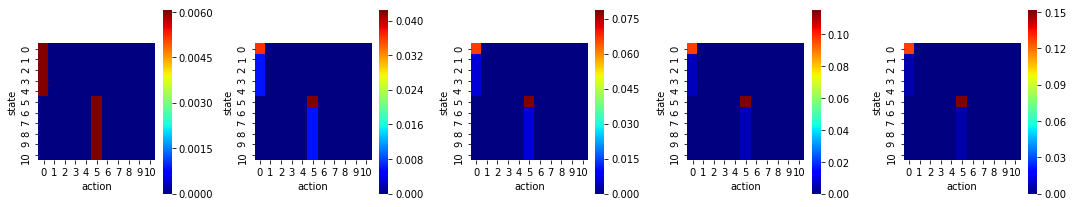

dR


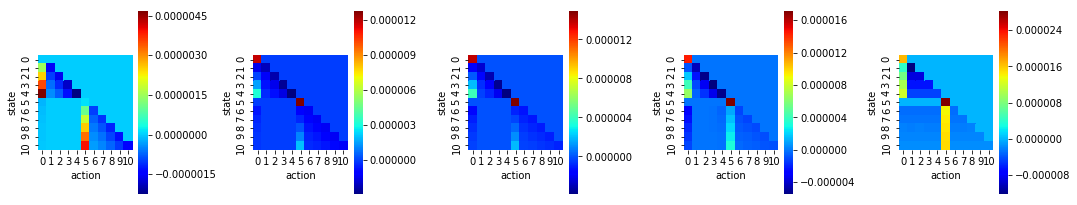

---------------------------------------------------------------------
70000 th iteration...
R


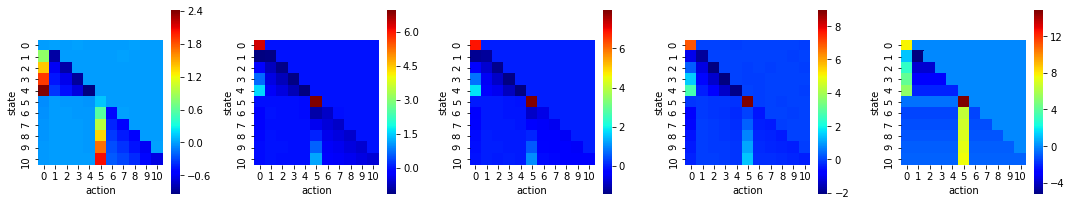

empirical feature density


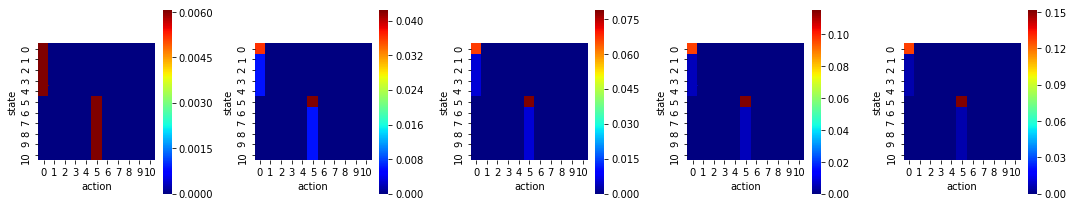

optimized feature density


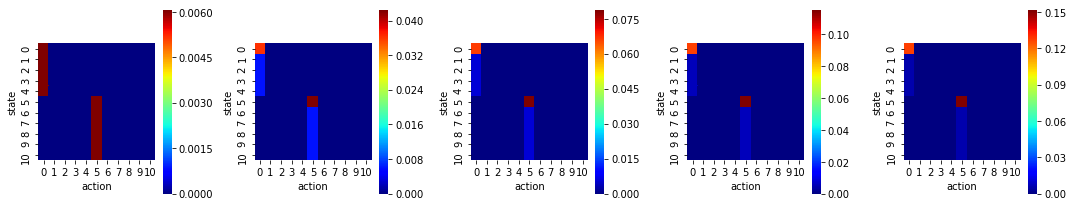

dR


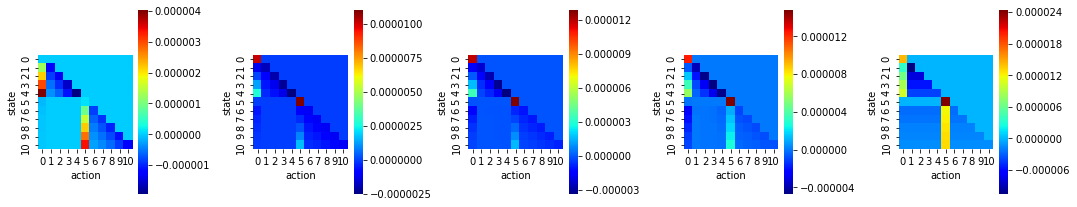

---------------------------------------------------------------------
80000 th iteration...
R


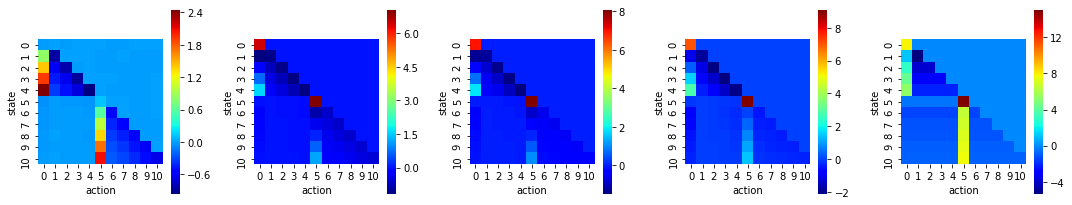

empirical feature density


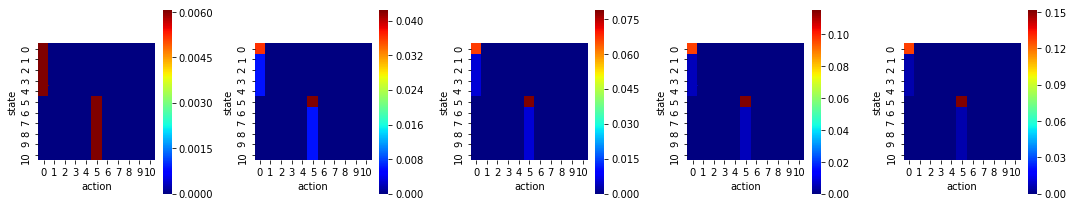

optimized feature density


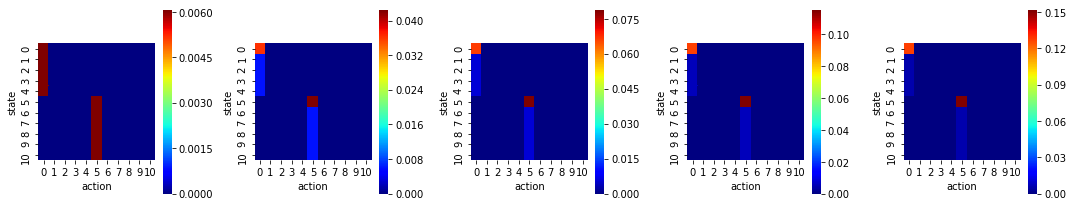

dR


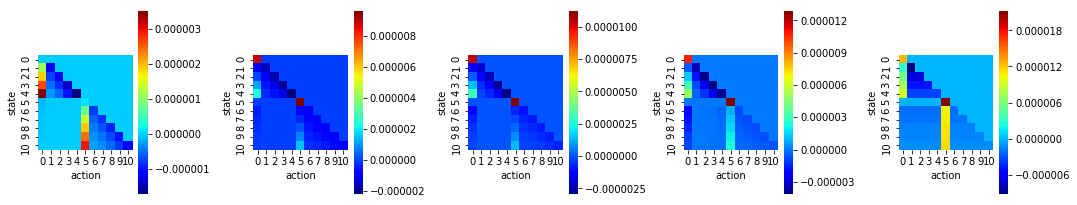

---------------------------------------------------------------------
90000 th iteration...
R


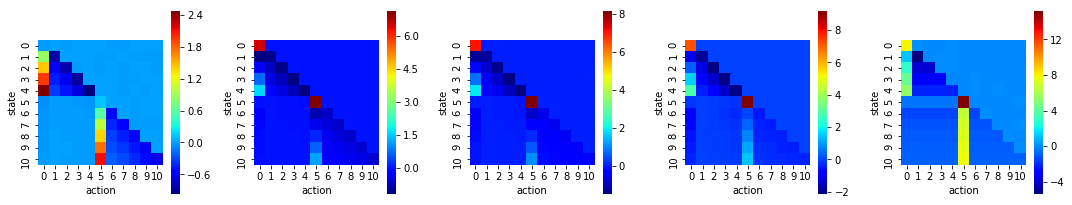

empirical feature density


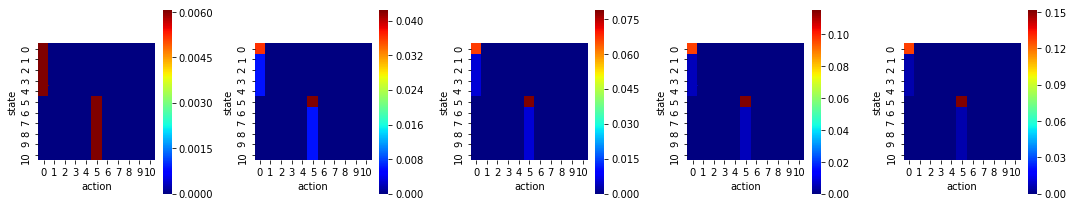

optimized feature density


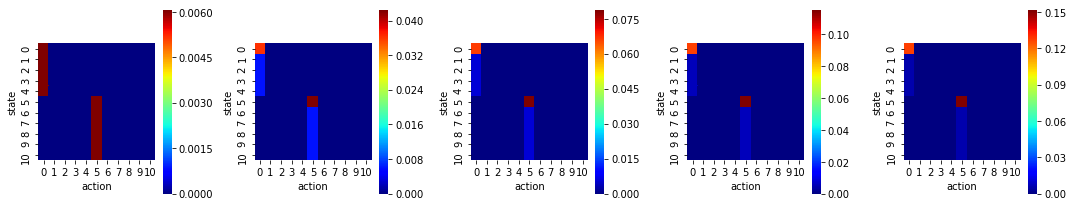

dR


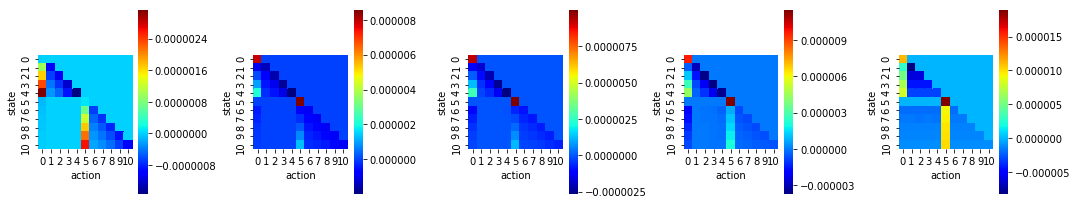

In [8]:
R = env.maximum_entropy(optimized_trajectories, learning_rate=1, n_iterations=100000, 
                    show_process=True, n_show_intervals=10000)

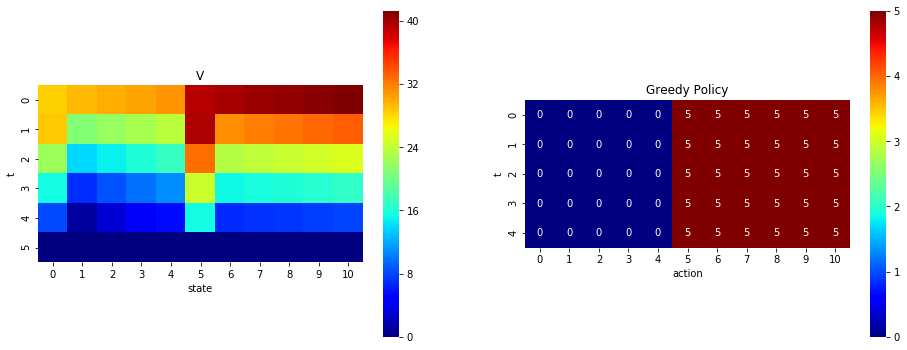

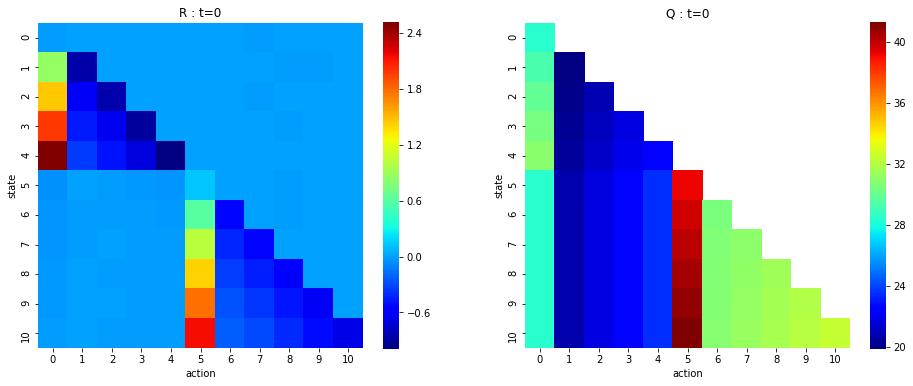

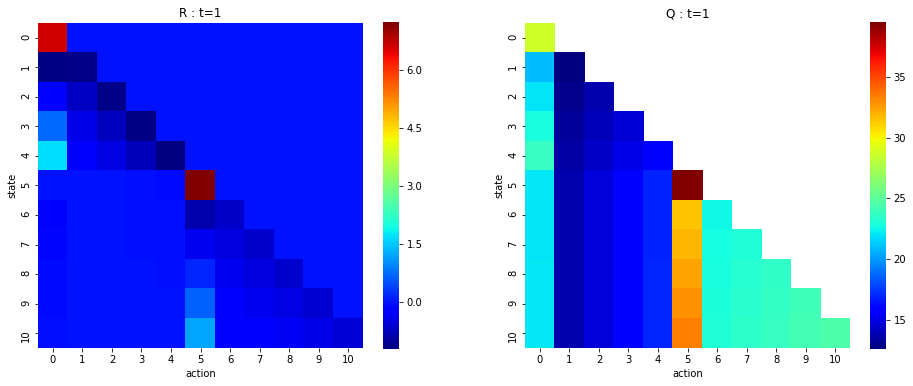

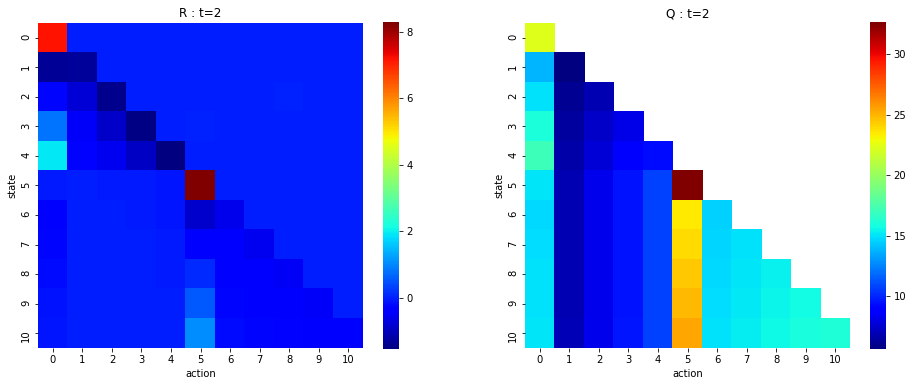

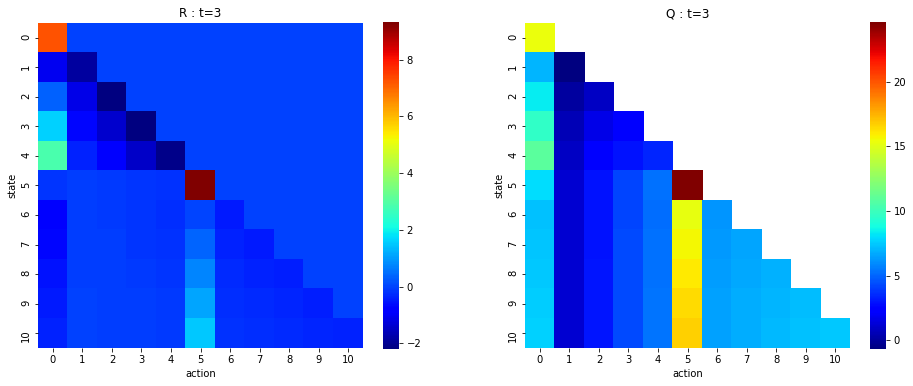

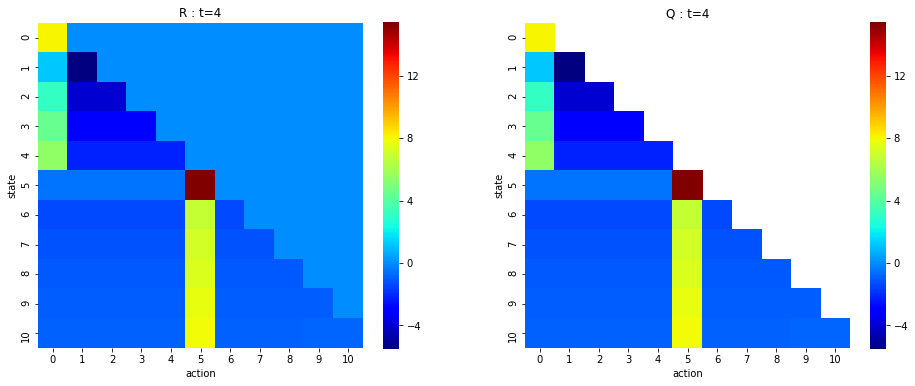

In [9]:
show_VPQ(env, R, annot=False)